# MULTICLASS LOGISTIC REGRESSION (SOFTMAX) WITH GLUON

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
from mxnet.gluon import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_ctx=mx.cpu
model_ctx=mx.cpu

In [3]:
batch_size = 200
num_inputs = 784
num_outputs = 10
num_examples = 60000

### the code belows loads the load the data and transform both the inputs and labels to float32 array. Since the input data has values between 0-255 we will then divide each value by 255 to have values between 0 and 1

In [4]:
def transform(data,labels):
    return data.astype('float32')/255, labels.astype('float32')
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True,transform=transform),batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),batch_size, shuffle=False)

### we first created a hybridsequential object name net then added a fully connected input,hidden and output layers

In [5]:
net=nn.HybridSequential()
#net.add(nn.Dense(num_outputs))
net.add(nn.Dense(units=50, activation='relu'))
net.add(nn.Dense(units=30, activation='relu'))  # input layer
net.add(nn.Dense(units=10, activation='relu'))   # inner layer 1
net.add(nn.Dense(units=5, activation='relu'))   # inner layer 2
net.add(nn.Dense(units=num_outputs)) 

#### initialized model parameters using Xavier initialization for weights designed to keep the scale of gradients roughly the same in all layers

In [6]:
net.initialize(mx.init.Xavier())

In [7]:
net.load_parameters

<bound method Block.load_parameters of HybridSequential(
  (0): Dense(None -> 50, Activation(relu))
  (1): Dense(None -> 30, Activation(relu))
  (2): Dense(None -> 10, Activation(relu))
  (3): Dense(None -> 5, Activation(relu))
  (4): Dense(None -> 10, linear)
)>

# loss function
A loss function— defines the feedback signal used for learning ( measures how well the model predictions match that of the true label)

In [8]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# Optimizer
An optimizer—A mechanism to update the model parameters

 we will use minibatch stochastic gradient descent with a learning rate of 0:5 as the optimization algorithm
 
## NOTE
The learning rate is tuning parameter which determines how big a step is taking along the gradient in order to find a better weight. A too high value will make the learning jump over the minima but smaller values slow it down and will take too long to converge

In [9]:
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':.005})

# Evaluation metrics to evaluate the model

In [10]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.reshape((-1,784))
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [11]:
evaluate_accuracy(test_data, net)

0.0566

# Training the model

In [12]:
epochs = 20
moving_loss = 0.
train_acc=[]
test_acc=[]
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1,784))
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))    
    

Epoch 0. Loss: 2.249564259847005, Train_acc 0.20191666666666666, Test_acc 0.2036
Epoch 1. Loss: 2.00652314453125, Train_acc 0.2830166666666667, Test_acc 0.2922
Epoch 2. Loss: 1.7843007110595703, Train_acc 0.38608333333333333, Test_acc 0.3859
Epoch 3. Loss: 1.5387312927246093, Train_acc 0.5131333333333333, Test_acc 0.5238
Epoch 4. Loss: 1.2518041399637858, Train_acc 0.5701666666666667, Test_acc 0.5756
Epoch 5. Loss: 1.0939023206075034, Train_acc 0.6251666666666666, Test_acc 0.6322
Epoch 6. Loss: 0.9930665153503418, Train_acc 0.6683, Test_acc 0.6738
Epoch 7. Loss: 0.9061790415445964, Train_acc 0.7112666666666667, Test_acc 0.7137
Epoch 8. Loss: 0.8188491966247559, Train_acc 0.7523166666666666, Test_acc 0.7571
Epoch 9. Loss: 0.7376959073384602, Train_acc 0.7808166666666667, Test_acc 0.7824
Epoch 10. Loss: 0.6725026210784912, Train_acc 0.8016833333333333, Test_acc 0.8069
Epoch 11. Loss: 0.6226720300038655, Train_acc 0.81785, Test_acc 0.8244
Epoch 12. Loss: 0.5831067169189453, Train_acc 0.82

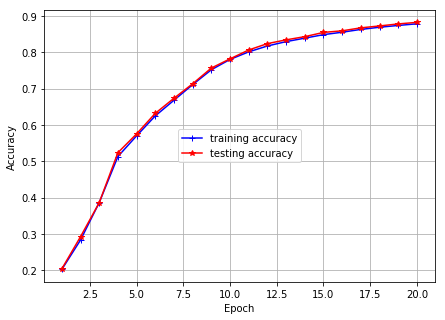

In [50]:
epoch=range(1,len(train_acc)+1)
with plt.style.context('seaborn-dark-palette'):
    plt.figure(figsize=(7,5))
    plt.plot(epoch,train_acc,'b-+',label='training accuracy')
    plt.plot(epoch,test_acc,'r-*',label='testing accuracy')
    plt.legend(loc='center')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')


(10, 28, 28, 1)


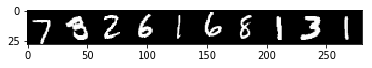

model predictions are: 
[7. 8. 2. 6. 1. 6. 8. 1. 3. 1.]
<NDArray 10 @cpu(0)>


In [52]:
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break
